In [ ]:
# Logistic Regression

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from benchmark import PerformanceMonitor

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def ClassPrintMetrics(y_real, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_real, y_pred)

    y_real_labels = list(map(str,sorted(y_real.unique().tolist())))

    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=y_real_labels)

    disp.plot()

    print(metrics.classification_report(y_real, y_pred))


dataset = pd.read_csv(r"..\data\processed\feature_all.txt", delimiter=" ")
print(dataset.columns.tolist())

c:\Users\Benedikt Lang\Desktop\IP_2\Modells\.venv\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


['Phishing?', 'has_ip', 'position_symbols_?_first', 'position_symbols_?_last', 'position_symbols_?_span', 'position_symbols_=_first', 'position_symbols_=_last', 'position_symbols_=_span', 'position_symbols_&_first', 'position_symbols_&_last', 'position_symbols_&_span', 'position_symbols_@_first', 'position_symbols_@_last', 'position_symbols_@_span', 'position_symbols_-_first', 'position_symbols_-_last', 'position_symbols_-_span', 'position_symbols_._first', 'position_symbols_._last', 'position_symbols_._span', 'position_symbols_#_first', 'position_symbols_#_last', 'position_symbols_#_span', 'position_symbols_%_first', 'position_symbols_%_last', 'position_symbols_%_span', 'position_symbols_/_first', 'position_symbols_/_last', 'position_symbols_/_span', 'count_int', 'has_suspicous_words_login', 'has_suspicous_words_signin', 'has_suspicous_words_signon', 'has_suspicous_words_password', 'has_suspicous_words_passwd', 'has_suspicous_words_passcode', 'has_suspicous_words_credential', 'has_sus

Phishing?
0    426156
1     81015
Name: count, dtype: int64

<Axes: >

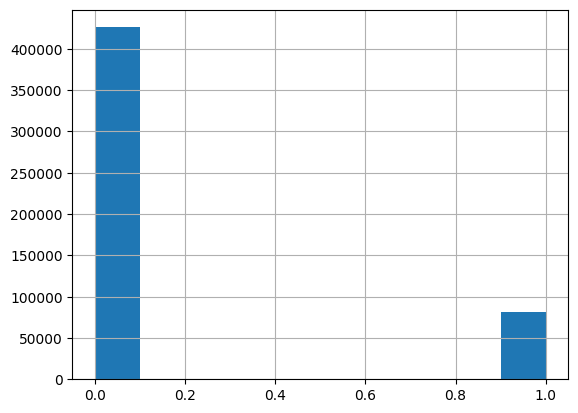

In [2]:
display(dataset["Phishing?"].value_counts())
# quality_num_bins = np.sort(dataset["Phishing?"].unique()) # Num bins = Num of unique target values
dataset["Phishing?"].hist()

In [3]:
url_train, url_dummy = train_test_split(dataset, test_size=0.2)
url_val, url_test = train_test_split(url_dummy, test_size=0.5)

In [4]:
url_train_x = url_train.drop(columns="Phishing?", inplace=False)
url_train_y = url_train["Phishing?"]

url_val_x = url_val.drop(columns="Phishing?", inplace=False)
url_val_y = url_val["Phishing?"]

url_test_x = url_test.drop(columns="Phishing?", inplace=False)
url_test_y = url_test["Phishing?"]

Training läuft auf: cuda
Starte Training für 500 Epochen...
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     42633
           1       0.90      0.72      0.80      8084

    accuracy                           0.94     50717
   macro avg       0.93      0.85      0.88     50717
weighted avg       0.94      0.94      0.94     50717

--- Ergebnisse Logistic Regression (Training) ---
Zeit: 15.1454s | GPU-Last: 87.8%
VRAM (System): 2436.42 MB | VRAM (Torch): 352.34 MB


{'model': 'Logistic Regression',
 'task': 'Training',
 'time_sec': 15.1454,
 'ram_mb': 3455.7,
 'vram_mb': 2436.42,
 'torch_vram_mb': 352.34,
 'cpu_percent': 96.2,
 'gpu_util_percent': 87.8}

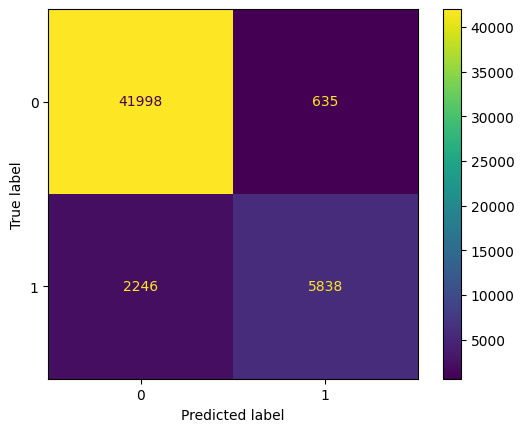

In [5]:
# --- LOGISTIC REGRESSION MIT GPU (PYTORCH) ---
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from benchmark import PerformanceMonitor

# Monitor starten
monitor = PerformanceMonitor("Logistic Regression")
monitor.start_measurement()

# 1. GPU Setup prüfen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training läuft auf: {device}")

# 2. PyTorch Model Definition (Wrapper, der sich wie sklearn verhält)
class GPULogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(GPULogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

    # Hilfsfunktion, um sklearn-API nachzubauen
    def fit(self, X, y, epochs=100, lr=0.01, batch_size=4096):
        self.to(device)
        self.train()
        
        # Daten zu Tensoren konvertieren
        # .values nutzen, falls es Pandas Dataframes sind
        X_np = X.values if hasattr(X, 'values') else X
        y_np = y.values if hasattr(y, 'values') else y
        
        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_np, dtype=torch.float32).view(-1, 1).to(device)
        
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        
        # Training Loop (Mini-Batch)
        num_samples = X_tensor.shape[0]
        num_batches = int(np.ceil(num_samples / batch_size))
        
        print(f"Starte Training für {epochs} Epochen...")
        for epoch in range(epochs):
            # Shuffle indices
            indices = torch.randperm(num_samples, device=device)
            
            for i in range(num_batches):
                start = i * batch_size
                end = min(start + batch_size, num_samples)
                batch_idx = indices[start:end]
                
                optimizer.zero_grad()
                outputs = self.forward(X_tensor[batch_idx])
                loss = criterion(outputs, y_tensor[batch_idx])
                loss.backward()
                optimizer.step()
                
    def predict(self, X):
        self.eval()
        with torch.no_grad():
            probs = self.predict_proba(X)[:, 1]
            return (probs >= 0.5).astype(int)

    def predict_proba(self, X):
        self.eval()
        X_np = X.values if hasattr(X, 'values') else X
        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            outputs = self.forward(X_tensor)
            probs = outputs.cpu().numpy().flatten()
            
        # Formatieren wie sklearn: [[prob_0, prob_1], ...]
        return np.vstack(((1 - probs), probs)).T

# 3. Modell initialisieren und trainieren
input_dim = url_train_x.shape[1]
log_reg = GPULogisticRegression(input_dim)

# Hyperparameter anpassen falls nötig (batch_size erhöht für GPU-Effizienz)
log_reg.fit(url_train_x, url_train_y, epochs=500, lr=0.001, batch_size=16384)

# 4. Validierung
wine_val_y_pred = log_reg.predict(url_val_x)
ClassPrintMetrics(url_val_y, wine_val_y_pred)

monitor.end_measurement(task_name="Training")

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# --- 5. INFERENZ & EVALUIERUNG ---
print("Starte Inferenz (gesamtes Testset)...")
monitor.start_measurement()

# 1. Vorhersage (Inferenz)
# Deine Klasse kümmert sich intern um .to(device) und .cpu()
# predict_proba gibt [[prob_0, prob_1], ...] zurück, wir brauchen Spalte 1
y_scores = log_reg.predict_proba(url_test_x)[:, 1]

# 2. Ground Truth (Echte Labels)
# Sicherstellen, dass es ein Numpy Array ist
y_true = url_test_y.values if hasattr(url_test_y, 'values') else url_test_y

# 3. Binäre Vorhersagen (Threshold 0.5)
y_pred_binary = (y_scores > 0.5).astype(int)

# --- METRIKEN BERECHNEN ---
# 1. Accuracy
acc = accuracy_score(y_true, y_pred_binary)
# 2. Precision
prec = precision_score(y_true, y_pred_binary, zero_division=0)
# 3. Recall
rec = recall_score(y_true, y_pred_binary, zero_division=0)
# 4. F1 Score
f1 = f1_score(y_true, y_pred_binary, zero_division=0)
# 5. AUC
auc = roc_auc_score(y_true, y_scores)

# 6. False Positive Rate (FPR)
# Confusion Matrix: tn, fp, fn, tp
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

# Ergebnisse zusammenpacken
metrics_dict = {
    "accuracy": round(acc, 4),
    "precision": round(prec, 4),
    "recall": round(rec, 4),
    "f1_score": round(f1, 4),
    "auc": round(auc, 4),
    "fpr": round(fpr, 4)
}

# An Monitor übergeben
monitor.end_measurement(task_name="Inferenz", extra_metrics=metrics_dict)

Starte Inferenz (gesamtes Testset)...
--- Ergebnisse Logistic Regression (Inferenz) ---
Zeit: 0.2012s | GPU-Last: 19.0%
VRAM (System): 2115.86 MB | VRAM (Torch): 55.53 MB


{'model': 'Logistic Regression',
 'task': 'Inferenz',
 'time_sec': 0.2012,
 'ram_mb': 3499.77,
 'vram_mb': 2115.86,
 'torch_vram_mb': 55.53,
 'cpu_percent': 715.8,
 'gpu_util_percent': 19.0,
 'accuracy': 0.9417,
 'precision': 0.8948,
 'recall': 0.7239,
 'f1_score': 0.8004,
 'auc': 0.9688,
 'fpr': np.float64(0.0164)}